In [16]:
import numpy as np
import os
import glob
import pandas as pd
from sklearn.manifold import Isomap,\
                            LocallyLinearEmbedding,\
                            SpectralEmbedding,\
                            TSNE,\
                            locally_linear_embedding
from umap import UMAP
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import ParameterGrid

from joblib import Parallel, delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from utils import transform, calculate_Q_mae, KNN_MAE
from IPython.display import clear_output
N_CPU = cpu_count()

import warnings
warnings.simplefilter("ignore")

# Load data

In [7]:
intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict.npy', allow_pickle=True).item()

data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values

data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')
        
embeddings_root = 'results/embeddings'
embeddings_params_root = 'results/embeddings_params/'

os.makedirs(embeddings_root, exist_ok=True)
os.makedirs(embeddings_params_root, exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]


In [40]:
for name, data in data_pca.items():
    print(name, (pdist(data) < 1e-4).any())

AGP_o False
AGP_f False
AGP_g False
HMP_o True
HMP_f True
HMP_g True


In [8]:
# # uncomment to use synthetic data

# intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

    
# embeddings_root = 'results/embeddings_synthetic'
# embeddings_params_root = 'results/embeddings_params_synthetic/'

# os.makedirs(embeddings_root, exist_ok=True)
# os.makedirs(embeddings_params_root, exist_ok=True)

# Hyperparameters Grid Search

In [9]:
knn_mae_scorer = lambda *args: KNN_MAE(*args, averaging='median', weights='distance', n_neighbors=4)
scorer = lambda *args: calculate_Q_mae(*args, mae_scorer=knn_mae_scorer)

In [ ]:
mf_models = {
#             'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[5,10,15,25],
#                                                       'p':[1,2],
#                                                       'n_jobs':[1],
#                                                       'metric':['minkowski']
#                                                       }
#                       },
#             'spectral':{'class':SpectralEmbedding,'params_grid':{'affinity':['nearest_neighbors', 'rbf'],
#                                                                  'n_neighbors':[5,10,15,25,50],
#                                                                   'gamma':[1e-4, 1e-3, 1e-2, None, 1e-1],
#                                                                   'n_jobs':[1],
#                                                                   'random_state':[42],
#                                                                   }
#                         }, 
#             'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['ltsa','modified', 'standard'],
#                                                                     'reg':[0.0001, 0.001, 0.01],
#                                                                    'n_neighbors':[10,15,25,30,50],
#                                                                    'random_state':[42],
#                                                                    'n_jobs':[1],
#                                                                    'eigen_solver':['dense']}
#                   },
#             'umap':{'class':UMAP, 'params_grid':{'n_neighbors':[5,10,15,25,50],
#                                                  'min_dist':[0.1, 0.2, 0.3, 0.4, 0.5],
#                                                  'random_state':[42],
#                                                  'metric':['euclidean','manhattan'],
#                                                  'learning_rate':[0.1, 0.5, 1],
#                                                  'n_epochs':[2000],
#                                                  'n_jobs':[1]}
#                    },
    
            'tsne':{'class':TSNE, 'params_grid':{'perplexity':[5,10,15,25,30,35],
                                                 'random_state':[42],
                                                 'early_exaggeration':[5,10,15,20,25,30,35],
                                                 'init':['pca'],
                                                 'metric':['euclidean','manhattan'],
                                                 'method':['exact'],
                                                 'n_jobs':[1],
                                                 'angle':[0.3, 0.6, 0.7],
                                                 'n_iter':[2000]
                                                 }
                   } 
            }

# iterate over the models
for mf_type, model in mf_models.items():    
    # iterate over the datasets
    for i,(label, X) in tqdm(enumerate(data_pca.items())):
        
        results = {}
        results_path = os.path.join(embeddings_params_root,\
                                    f'pca_{mf_type}_{label}')
        
        if os.path.isfile(results_path + '.npy'):
            print(f'{results_path} exists, skipping...')
            continue

        dim = intrinsic_dims[label]
        print('Calculating...', label, 'Method:', mf_type, 'Intrinsic dim:', dim)
        
        # to avoid errors in lle model
        if mf_type=='lle':
            model['params_grid']['n_neighbors'] = list(map(lambda x: max(x,dim+1),\
                                                              model['params_grid']['n_neighbors']))
            assert len(model['params_grid']['n_neighbors']) > 0

        model_class = model['class']
        model_param_grid = model['params_grid']
        
        try:
            scores = Parallel(n_jobs=N_CPU//2)(delayed(transform)(model_class,
                                                            X, 
                                                            dim,
                                                            model_params,
                                                            scorer) \
                              for model_params in list(ParameterGrid(model_param_grid)))  
            
            results['scores'] = scores
            results['params'] = model_param_grid
            np.save(results_path, results)
            
        except Exception as e:
            print(f'Failed to estimate perameters for {mf_type}, {label}:', e)
            continue
            
clear_output()

6it [00:00, 2761.83it/s]


results/embeddings_params/mf_learning_metrics_results_pca_isomap_AGP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_isomap_AGP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_isomap_AGP_g exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_isomap_HMP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_isomap_HMP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_isomap_HMP_g exists, skipping...


6it [00:00, 5416.66it/s]


results/embeddings_params/mf_learning_metrics_results_pca_spectral_AGP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_spectral_AGP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_spectral_AGP_g exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_spectral_HMP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_spectral_HMP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_spectral_HMP_g exists, skipping...


6it [00:00, 4360.74it/s]


results/embeddings_params/mf_learning_metrics_results_pca_lle_AGP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_lle_AGP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_lle_AGP_g exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_lle_HMP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_lle_HMP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_lle_HMP_g exists, skipping...


6it [00:00, 4848.91it/s]


results/embeddings_params/mf_learning_metrics_results_pca_umap_AGP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_umap_AGP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_umap_AGP_g exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_umap_HMP_o exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_umap_HMP_f exists, skipping...
results/embeddings_params/mf_learning_metrics_results_pca_umap_HMP_g exists, skipping...


0it [00:00, ?it/s]

Calculating... AGP_o Method: tsne Intrinsic dim: 5


# Visualization

In [59]:
all_metrics = defaultdict(dict)

for metrics_results_name in \
                   filter(lambda x: 'pca' in x, os.listdir(embeddings_params_root)):
    
    mf_type, dataset_name, tax_name = metrics_results_name.split('.')[0].split('_')[-3:]
    label = '_'.join([dataset_name, tax_name])
    all_metrics[mf_type][label] = np.load(os.path.join(embeddings_params_root, 
                                          metrics_results_name), \
                                          allow_pickle=True).item()

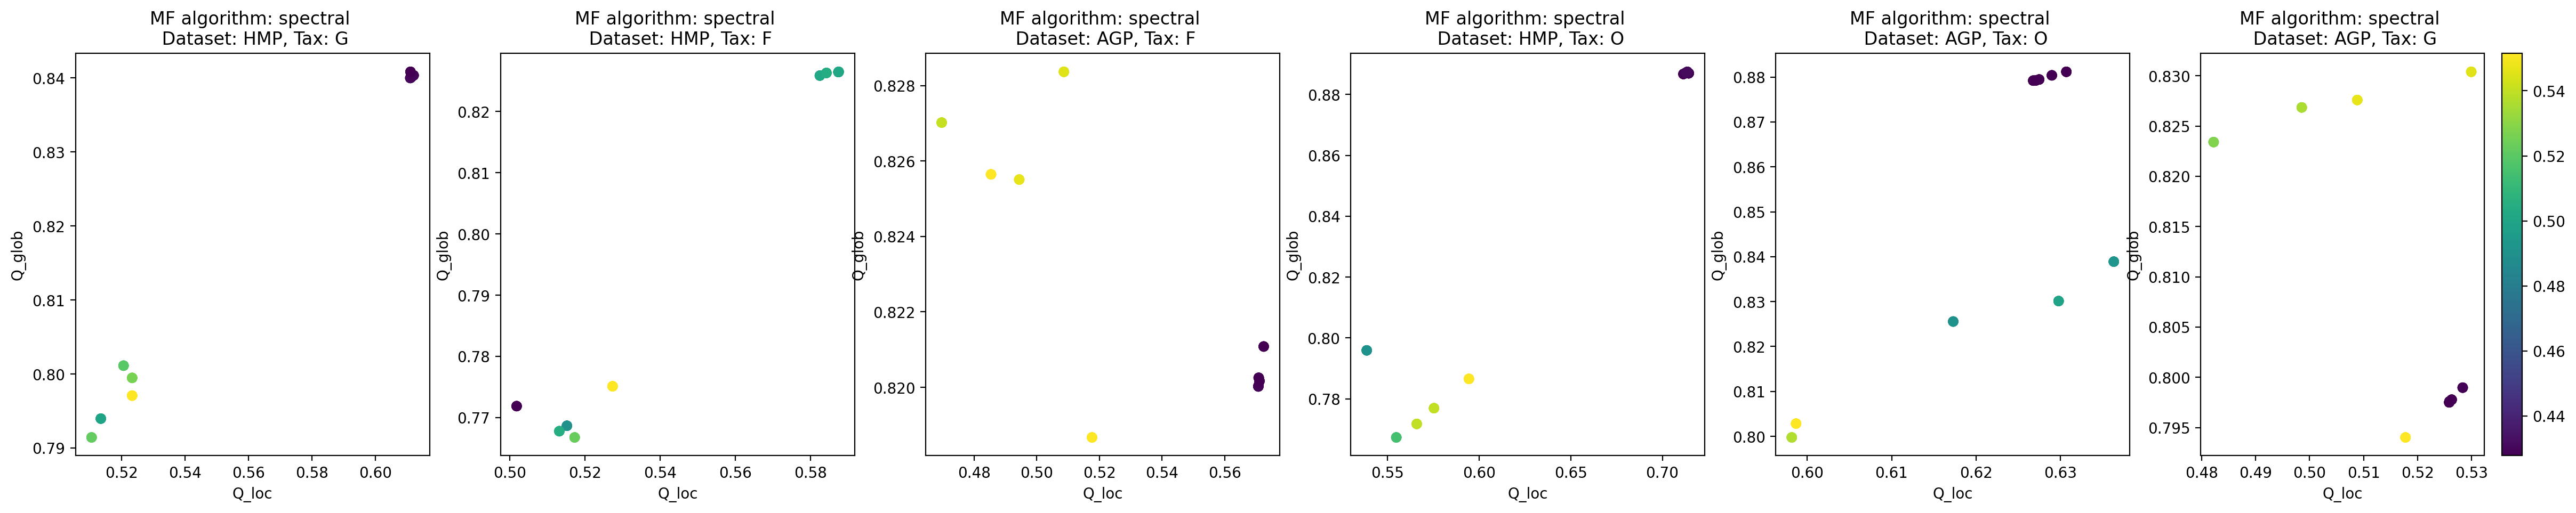

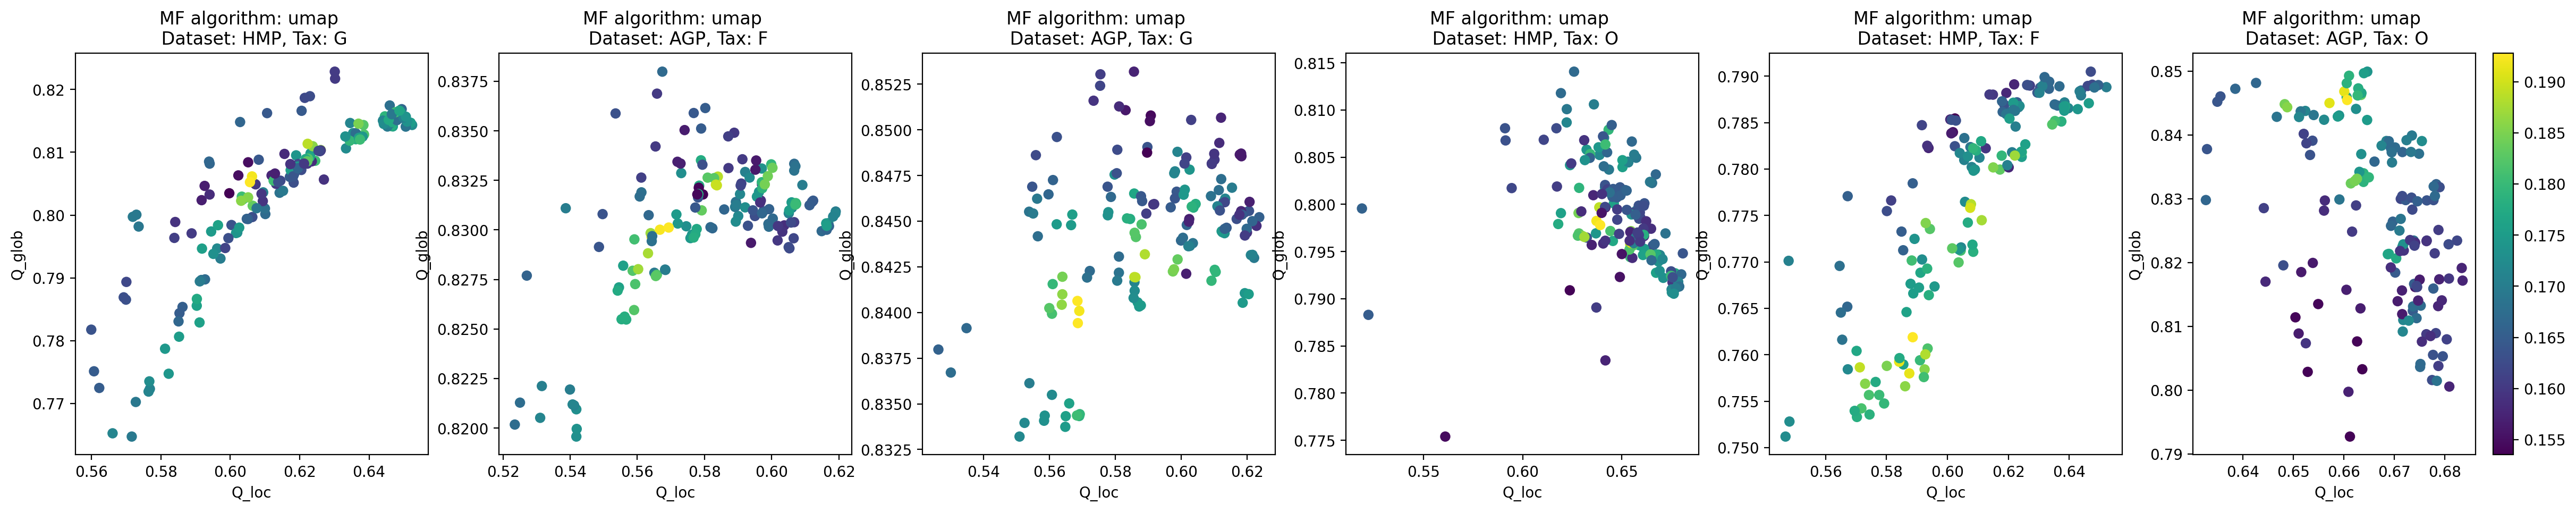

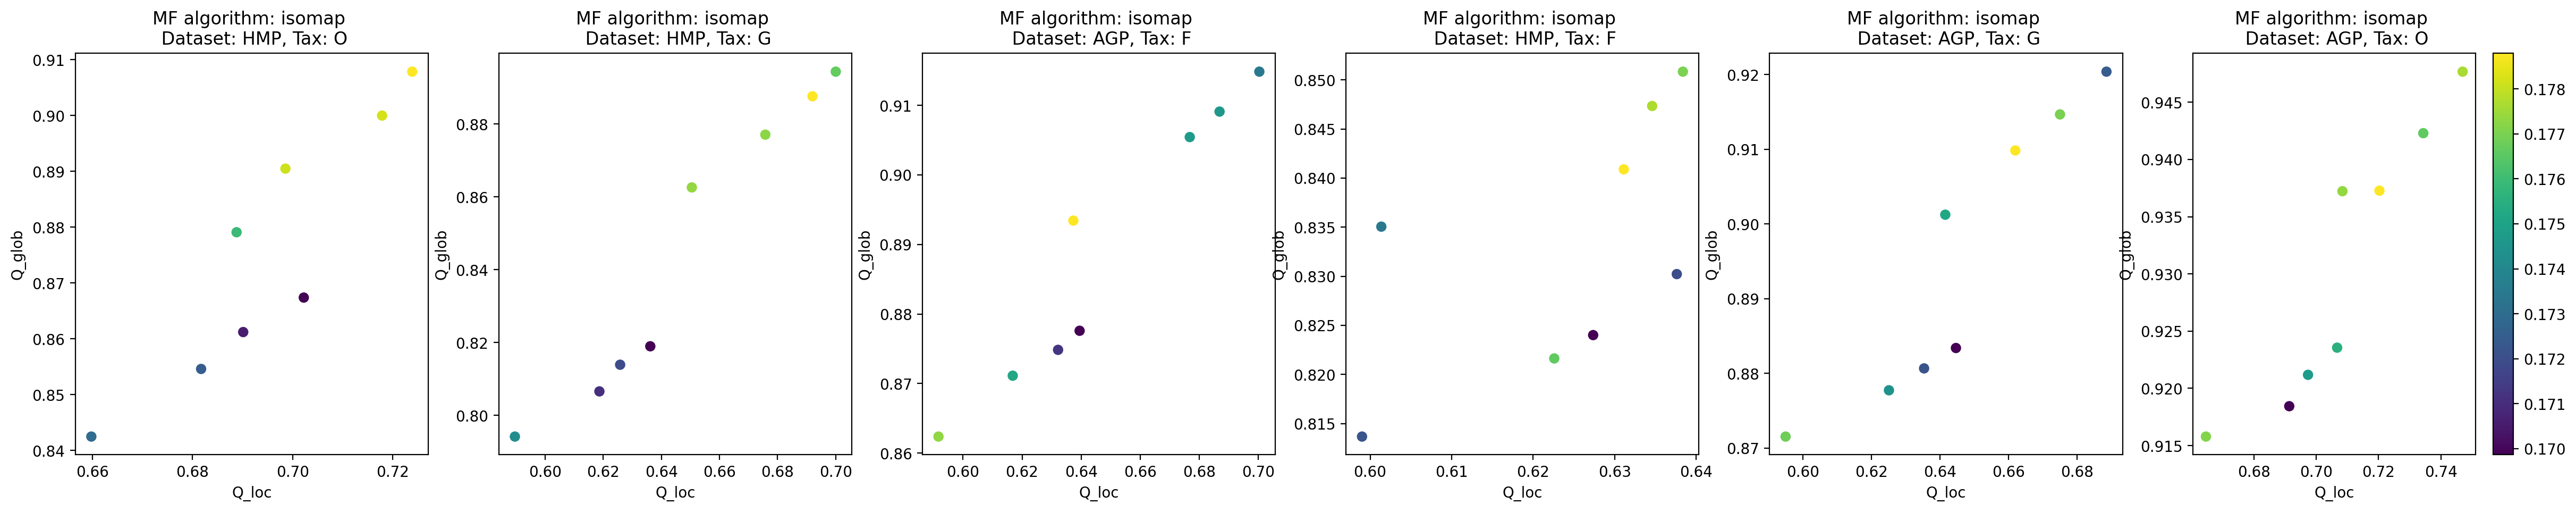

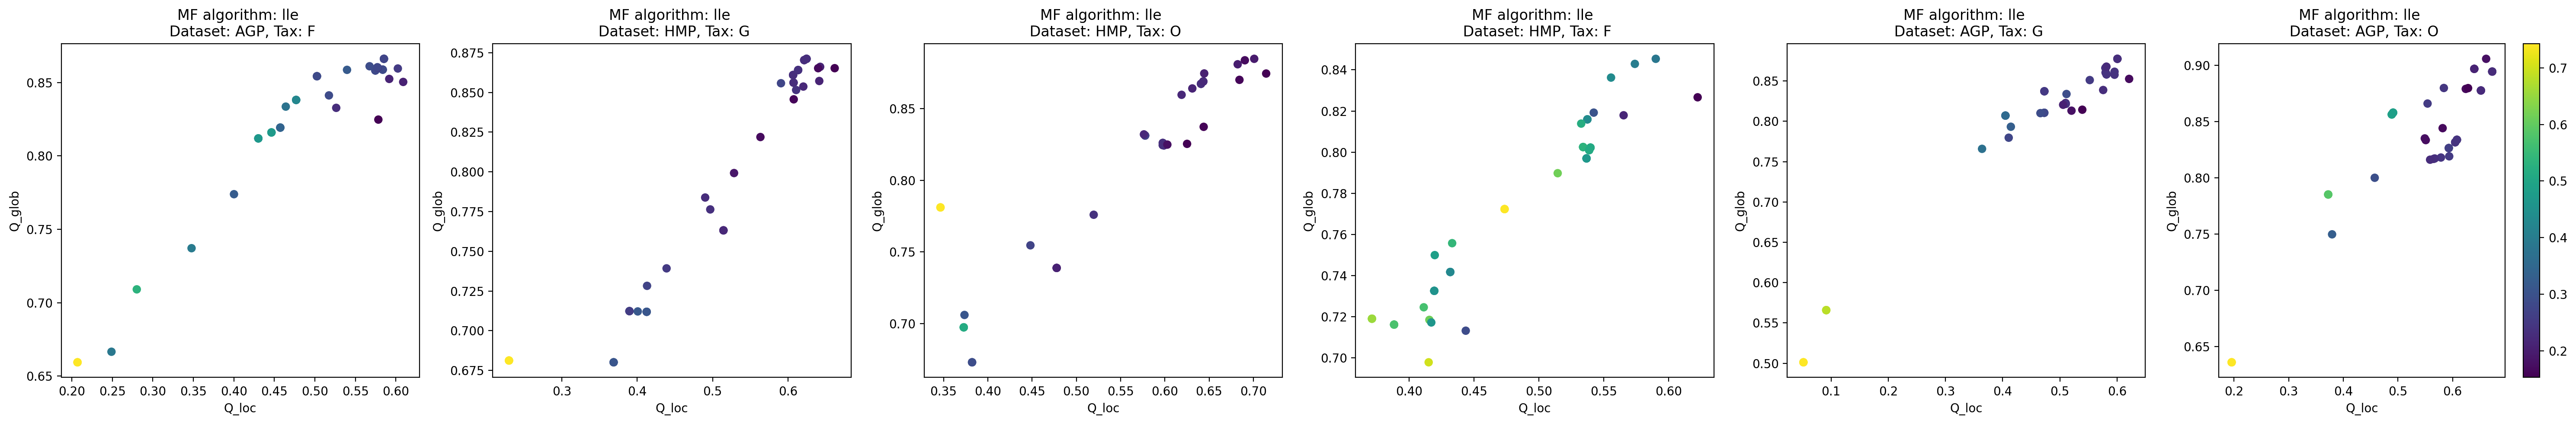

In [66]:
for mf_type, mf_metrics in all_metrics.items():
    mf_metrics_items = mf_metrics.items()
    
    fig, axes = plt.subplots(nrows=1, ncols = len(mf_metrics_items), figsize=(len(mf_metrics_items)*5,5), dpi=200)
    
    for i,(label, mf_label_metrics) in enumerate(mf_metrics_items):
        
        scores = np.array(mf_label_metrics['scores'])
        params = list(ParameterGrid(mf_label_metrics['params']))
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1]

        sc = axes[i].scatter(scores[:,0], scores[:,1], c=scores[:,2])
        
        axes[i].set_title(f'MF algorithm: {mf_type} \n Dataset: {dataset_name}, Tax: {tax_name.capitalize()}')
        axes[i].set_xlabel('Q_loc')
        axes[i].set_ylabel('Q_glob')
    fig.colorbar(sc, orientation='vertical')
plt.tight_layout()        
plt.show()

 # Create embeddings for the best params

In [67]:
best_params = defaultdict(dict)

for mf_type, mf_metrics in all_metrics.items():
    mf_metrics_items = mf_metrics.items()
    for i,(label, mf_label_metrics) in enumerate(mf_metrics_items):
        
        scores = np.array(mf_label_metrics['scores'])
        params = np.array(list(ParameterGrid(mf_label_metrics['params'])))
        
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1]
        
        maes = scores[:,-1]
        qloc = scores[:,0]
        qglob = scores[:,1]
        
        mae_argmin = maes.argmin()
        
        best_params[label][mf_type] = {}
        best_params[label][mf_type]['best_params_mae'] = params[mae_argmin] 
        best_params[label][mf_type]['mae'] = maes[mae_argmin]
        best_params[label][mf_type]['Q_loc'] = qloc[mae_argmin]
        best_params[label][mf_type]['Q_glob'] = qglob[mae_argmin]            


In [74]:
methods_dict = {'tsne':TSNE,
#                 'lle':LocallyLinearEmbedding,
#                 'umap':UMAP,
#                 'isomap':Isomap,
#                 'spectral':SpectralEmbedding
               }

In [75]:
PERCENTILE = 95
DATA_PERCENT_THRESHOLD = 0.9

for label, best_params_ in tqdm(best_params.items()):
    
    X = data_pca[label]
    X_orig  = data_orig[label]
    intdim = intrinsic_dims[label]

    for method_name, params_dict in best_params_.items():
        
        embedding_path = os.path.join(embeddings_root, f'{label}_{method_name}')

        if os.path.isfile(embedding_path + '.npy'):
            print(embedding_path, f'Loading {method_name} for {label}...') 
            d = np.load(embedding_path + '.npy', allow_pickle=True).item()
            Q_loc = d['Q_loc']
            Q_glob = d['Q_glob']
            mae = d['knn_mae_loo_orig']
            
            Q_loc_ = d['Q_loc_']
            Q_glob_ = d['Q_glob_']
            mae_ = d['knn_mae_loo_orig_']
            
        else:
            print(embedding_path, f'Calculating {method_name} for {label}...')  

            d = {}

            d['method_name'] = method_name
            d['parameters'] = params_dict[f'best_params_mae']
            d['label'] = label
            d['Q_loc'] = params_dict['Q_loc']
            d['Q_glob'] = params_dict['Q_glob']
            d['intrinsic_dim'] = intdim

            print('Learning...')
            d['parameters']['n_jobs'] = -1
            Z = methods_dict[method_name](n_components=intdim,
                                          **d['parameters']).fit_transform(X)

            d['Z'] = Z

            mae = KNN_MAE(X_orig, Z, averaging='median', weights='distance')
            d['knn_mae_loo_orig'] = mae

            N = X_orig.shape[0]
            X_ = X_orig.copy()
            Z_ = Z.copy() 

            inliers_indexes = np.arange(N)
            maxiter = 20
            for _ in range(maxiter):
                scoring_list = KNN_MAE(X_, Z_, averaging=None, weights='distance') 
                q = np.percentile(scoring_list, PERCENTILE)
                mask = scoring_list < q
                if mask.sum()/N < DATA_PERCENT_THRESHOLD:
                    break
                X_ = X_[mask]
                Z_ = Z_[mask]
                inliers_indexes = inliers_indexes[mask]

            outliers_indexes = np.array(list(set(np.arange(N)) - set(inliers_indexes)))
            Q_loc_, Q_glob_, mae_ = scorer(X_, Z_)

            d['inliers_indexes_mae'] = inliers_indexes
            d['outliers_indexes_mae'] = outliers_indexes
            d['X_'] = X_
            d['Z_'] = Z_ # final embedding
            d['Q_loc_'] = Q_loc_ 
            d['Q_glob_'] = Q_glob_ 
            d['knn_mae_loo_orig_'] = mae_ # final mae

            Q_loc = d['Q_loc']
            Q_glob = d['Q_glob'] 
            
            np.save(embedding_path, d)   
            
        print(f'Initial metrics: mae={mae}, Q_loc={Q_loc}, Q_glob={Q_glob}') 
        print(f'After removing outliers: mae={mae_}, Q_loc={Q_loc_}, Q_glob={Q_glob_}')
        print('-----------------------------------------------------------','\n')


  0%|                                                                                                                                                  | 0/6 [00:00<?, ?it/s]

results/embeddings/HMP_g_spectral Loading spectral for HMP_g...
Initial metrics: mae=0.3162041922470126, Q_loc=0.6110911831248858, Q_glob=0.8408271852425842
After removing outliers: mae=0.28069987541933683, Q_loc=0.651162517573646, Q_glob=0.8587549255353499
----------------------------------------------------------- 

results/embeddings/HMP_g_umap Loading umap for HMP_g...
Initial metrics: mae=0.2847812465523253, Q_loc=0.5997414116224197, Q_glob=0.8034757693950659
After removing outliers: mae=0.2542351699749795, Q_loc=0.6219858655343229, Q_glob=0.8150115973549125
----------------------------------------------------------- 

results/embeddings/HMP_g_isomap Loading isomap for HMP_g...


 17%|███████████████████████                                                                                                                   | 1/6 [00:00<00:01,  3.24it/s]

Initial metrics: mae=0.29730584862335946, Q_loc=0.6362063265252673, Q_glob=0.8189867750849785
After removing outliers: mae=0.2661032833056694, Q_loc=0.6476876221163363, Q_glob=0.825708854181427
----------------------------------------------------------- 

results/embeddings/HMP_g_lle Loading lle for HMP_g...
Initial metrics: mae=0.2905171846723005, Q_loc=0.6618989137614161, Q_glob=0.8652900612304062
After removing outliers: mae=0.26171548103423126, Q_loc=0.6873474742868586, Q_glob=0.878470831954539
----------------------------------------------------------- 

results/embeddings/HMP_f_spectral Loading spectral for HMP_f...
Initial metrics: mae=0.3773283133405386, Q_loc=0.5018586312315125, Q_glob=0.7718752517947591
After removing outliers: mae=0.341184101683041, Q_loc=0.5123872811225735, Q_glob=0.777018160346219
----------------------------------------------------------- 

results/embeddings/HMP_f_umap Loading umap for HMP_f...
Initial metrics: mae=0.30088185493060904, Q_loc=0.6024669062

 33%|██████████████████████████████████████████████                                                                                            | 2/6 [00:00<00:00,  4.34it/s]

Initial metrics: mae=0.32946149606826947, Q_loc=0.6273592665933098, Q_glob=0.8240080440747583
After removing outliers: mae=0.29856021464809135, Q_loc=0.6479689288595658, Q_glob=0.8326955790110047
----------------------------------------------------------- 

results/embeddings/HMP_f_lle Loading lle for HMP_f...
Initial metrics: mae=0.31639718528610816, Q_loc=0.6223600106059559, Q_glob=0.8266759884077648
After removing outliers: mae=0.2888513356155465, Q_loc=0.6451030710388267, Q_glob=0.8374040474045916
----------------------------------------------------------- 

results/embeddings/AGP_f_spectral Loading spectral for AGP_f...
Initial metrics: mae=0.23150306550303967, Q_loc=0.5724028456018215, Q_glob=0.8210825706510495
After removing outliers: mae=0.21675226575981554, Q_loc=0.5907785161374316, Q_glob=0.8276094650068613
----------------------------------------------------------- 

results/embeddings/AGP_f_umap Loading umap for AGP_f...
Initial metrics: mae=0.23163469928702105, Q_loc=0.579

 67%|████████████████████████████████████████████████████████████████████████████████████████████                                              | 4/6 [00:00<00:00,  5.05it/s]

Initial metrics: mae=0.2386945665684839, Q_loc=0.6394927041251742, Q_glob=0.8775942164140826
After removing outliers: mae=0.22493491852723088, Q_loc=0.6553044479019398, Q_glob=0.8871725303706162
----------------------------------------------------------- 

results/embeddings/AGP_f_lle Loading lle for AGP_f...
Initial metrics: mae=0.22532683627347008, Q_loc=0.5783814432920206, Q_glob=0.8247384671685394
After removing outliers: mae=0.21140768644843566, Q_loc=0.5972097421000365, Q_glob=0.8325756675242973
----------------------------------------------------------- 

results/embeddings/HMP_o_spectral Loading spectral for HMP_o...
Initial metrics: mae=0.14778528618583195, Q_loc=0.7143933059528202, Q_glob=0.886995422693884
After removing outliers: mae=0.1247808749120331, Q_loc=0.7416524728237012, Q_glob=0.9036771604365167
----------------------------------------------------------- 

results/embeddings/HMP_o_umap Loading umap for HMP_o...
Initial metrics: mae=0.12813415729889974, Q_loc=0.64183

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 5/6 [00:01<00:00,  5.40it/s]

Initial metrics: mae=0.07565320316026745, Q_loc=0.6289881158772035, Q_glob=0.8803723415918642
After removing outliers: mae=0.06825413981034248, Q_loc=0.6366750971376185, Q_glob=0.891487088066353
----------------------------------------------------------- 

results/embeddings/AGP_o_umap Loading umap for AGP_o...
Initial metrics: mae=0.06776267871772651, Q_loc=0.6636858596956355, Q_glob=0.8032767576193465
After removing outliers: mae=0.06169576525301321, Q_loc=0.6712272458095226, Q_glob=0.8364411827979851
----------------------------------------------------------- 

results/embeddings/AGP_o_isomap Loading isomap for AGP_o...
Initial metrics: mae=0.07442991350584369, Q_loc=0.6913612517841105, Q_glob=0.9184422770671401
After removing outliers: mae=0.06783689913816333, Q_loc=0.7102863362335259, Q_glob=0.9351597039255606
----------------------------------------------------------- 

results/embeddings/AGP_o_lle Loading lle for AGP_o...
Initial metrics: mae=0.06904189055835891, Q_loc=0.6284508

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]

Initial metrics: mae=0.2694798091053635, Q_loc=0.6446546900189454, Q_glob=0.8833957694943426
After removing outliers: mae=0.25584993966661684, Q_loc=0.660634631825101, Q_glob=0.893104005695737
----------------------------------------------------------- 

results/embeddings/AGP_g_lle Loading lle for AGP_g...
Initial metrics: mae=0.25883332795258074, Q_loc=0.5391510555363715, Q_glob=0.8144029278951629
After removing outliers: mae=0.24411579754818735, Q_loc=0.5561539351994714, Q_glob=0.8236741300155204
----------------------------------------------------------- 

